In [19]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Data generation
raw_data = np.loadtxt("https://raw.githubusercontent.com/priyasam9/Ensembel-GAN/master/BreastCancerData.csv", delimiter=",",skiprows=1)

In [21]:
# Split Data into four pieces
full_size = len(raw_data)
n_subsets = 4
sub_size = full_size // n_subsets

subsets = []
for k in range(4):
    subsets.append(raw_data[k*sub_size:(k+1)*sub_size, k:k+27])
    
print("Split data into", n_subsets, "subsets. Size of one subset:", sub_size)

Split data into 4 subsets. Size of one subset: 142


In [22]:
# Apply GAIN on the first dataset
Data = subsets[3]
# Data = raw_data

In [23]:
#%% System Parameters
# 1. Mini batch size
mb_size = 100
# 2. Missing rate
p_miss = 0.2
# 3. Hint rate
p_hint = 0.9
# 4. Loss Hyperparameters
alpha = 10
# 5. Train Rate
train_rate = 114

# Parameters
No = len(Data)
Dim = len(Data[0,:])

# Hidden state dimensions
H_Dim1 = Dim
H_Dim2 = Dim

print(Dim)

27


In [6]:
# Normalization (0 to 1)
Min_Val = np.zeros(Dim)
Max_Val = np.zeros(Dim)

for i in range(Dim):
    Min_Val[i] = np.min(Data[:,i])
    Data[:,i] = Data[:,i] - np.min(Data[:,i])
    Max_Val[i] = np.max(Data[:,i])
    Data[:,i] = Data[:,i] / (np.max(Data[:,i]) + 1e-6)    

#%% Missing introducing
p_miss_vec = p_miss * np.ones((Dim,1)) 
   
Missing = np.zeros((No,Dim))

for i in range(Dim):
    A = np.random.uniform(0., 1., size = [len(Data),])
    B = A > p_miss_vec[i]
    Missing[:,i] = 1.*B

In [7]:
#%% Train Test Division    
   
idx = np.random.permutation(No)

Train_No = int(train_rate)
Test_No = No - Train_No
    
# Train / Test Features
trainX = Data[idx[:Train_No],:]
testX = Data[idx[Train_No:],:]

# Train / Test Missing Indicators
trainM = Missing[idx[:Train_No],:]
testM = Missing[idx[Train_No:],:]

In [8]:
#%% Necessary Functions

# 1. Xavier Initialization Definition
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape = size, stddev = xavier_stddev)
    
# Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C

## GAIN Model
- Generator
- Discriminator
- Hint Mechanism

In [9]:
#%% GAIN Architecture   
   
#%% 1. Input Placeholders
# 1.1. Data Vector
X = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.2. Mask Vector 
M = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.3. Hint vector
H = tf.placeholder(tf.float32, shape = [None, Dim])
# 1.4. X with missing values
New_X = tf.placeholder(tf.float32, shape = [None, Dim])

In [10]:
#%% 2. Discriminator
D_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]), name="D_W1")     # Data + Hint as inputs
D_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]), name="D_b1")

#D_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]), name="D_W2")
D_W2 = tf.Variable(xavier_init([27, 42]), name="D_W2")
#D_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]), name="D_b2")
D_b2 = tf.Variable(tf.zeros(shape = [42]), name="D_b2")

#D_W3 = tf.Variable(xavier_init([H_Dim2, Dim]), name="D_W3")
D_W3 = tf.Variable(xavier_init([42, Dim]), name="D_W3")
D_b3 = tf.Variable(tf.zeros(shape = [Dim]), name="D_b3")       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

In [11]:
#%% 3. Generator
G_W1 = tf.Variable(xavier_init([Dim*2, H_Dim1]), name="G_W1")     # Data + Mask as inputs (Random Noises are in Missing Components)
G_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]), name="G_b1")

#G_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]), name="G_W2")
G_W2 = tf.Variable(xavier_init([27, 42]), name="G_W2")
#G_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]), name="G_b2")
G_b2 = tf.Variable(tf.zeros(shape = [42]), name="G_b2")

#G_W3 = tf.Variable(xavier_init([H_Dim2, Dim]), name="G_W3")
G_W3 = tf.Variable(xavier_init([42, Dim]), name="G_W3")
G_b3 = tf.Variable(tf.zeros(shape = [Dim]), name="G_b3")

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [12]:
#%% GAIN Function

#%% 1. Generator
def generator(new_x,m):
    inputs = tf.concat(axis = 1, values = [new_x,m])  # Mask + Data Concatenate
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    
    return G_prob
    
#%% 2. Discriminator
def discriminator(new_x, h):
    inputs = tf.concat(axis = 1, values = [new_x,h])  # Hint + Data Concatenate
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)  # [0,1] Probability Output
    
    return D_prob

In [13]:
#%% 3. Other functions
# Random sample generator for Z
def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size = [m, n])        

# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

In [14]:
#%% Structure
# Generator
G_sample = generator(New_X,M)

# Combine with original data
Hat_New_X = New_X * M + G_sample * (1-M)

# Discriminator
D_prob = discriminator(Hat_New_X, H)

#%% Loss
D_loss1 = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1-M) * tf.log(1. - D_prob + 1e-8)) 
G_loss1 = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
MSE_train_loss = tf.reduce_mean((M * New_X - M * G_sample)**2) / tf.reduce_mean(M)

D_loss = D_loss1
G_loss = G_loss1 + alpha * MSE_train_loss 

#%% MSE Performance metric
MSE_test_loss = tf.reduce_mean(((1-M) * X - (1-M)*G_sample)**2) / tf.reduce_mean(1-M)

#%% Solver
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [15]:
# Sessions
import time
sess1 = tf.Session()
sess1.run(tf.global_variables_initializer())

#%% Iterations
train_losses = []
test_losses = []

#%% Start Iterations
t=time.time()
for it in tqdm(range(1000)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
#     M_mb = trainM[mb_idx,:]  
    M_mb = trainM[:mb_size, :]
    H_mb1 = sample_M(mb_size, Dim, 1-p_hint)
    H_mb = M_mb * H_mb1
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, D_loss_curr = sess1.run([D_solver, D_loss1], feed_dict = {M: M_mb, New_X: New_X_mb, H: H_mb})
    _, G_loss_curr, MSE_train_loss_curr, MSE_test_loss_curr = sess1.run([G_solver, G_loss1, MSE_train_loss, MSE_test_loss],
                                                                       feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb})
            
        
    #%% Intermediate Losses
#     if it % 100 == 0:
#         print('Iter: {}'.format(it))
#         print('Train_loss: {:.4}'.format(np.sqrt(MSE_train_loss_curr)))
#         print('Test_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
#         print()
    train_losses.append(np.sqrt(MSE_train_loss_curr))
    test_losses.append(np.sqrt(MSE_test_loss_curr))
    
#%% Final Loss
t_final=time.time()    
Z_mb = sample_Z(Test_No, Dim) 
M_mb = testM
X_mb = testX
        
New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
MSE_final, Sample = sess1.run([MSE_test_loss, G_sample], feed_dict = {X: testX, M: testM, New_X: New_X_mb})
        
print('Final Test RMSE: ' + str(np.sqrt(MSE_final)))
print('Time cost: ',t_final-t)
sess1.close()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.05it/s]


Final Test RMSE: 0.082017265
Time cost:  2.315523862838745


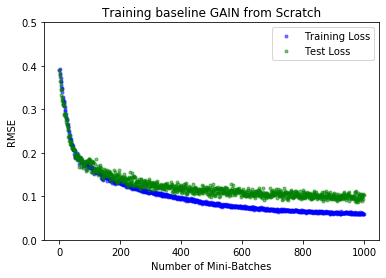

In [18]:
# Plot training curve
plt.plot(train_losses, 'b.', label="Training Loss", alpha=0.5)
plt.plot(test_losses, 'g.', label="Test Loss", alpha=0.5)
plt.title("Training baseline GAIN from Scratch")
plt.xlabel("Number of Mini-Batches")
plt.ylabel("RMSE")
plt.ylim(0,0.5)
plt.legend()
plt.savefig("GAIN_Baseline.png")
plt.show()